# Word2Vec con Tokens de 6-gramas de Hipnogramas

Este cuaderno prepara el corpus de hipnogramas para entrenar modelos Word2Vec en PyTorch usando:

- **Tokens principales**: ventanas deslizantes de 6 etapas consecutivas (6-gramas).
- **Tokens auxiliares**: etapas individuales (unigramas) para comparar espacios embebidos.

La meta es obtener embeddings que capturen patrones de arquitectura del sueño a distintas escalas temporales.

## 1. Plan de trabajo

1. Cargar hipnogramas de todos los pacientes **_2**.
2. Generar dos corpus sincronizados:
   - Secuencias de 6-gramas como tokens principales.
   - Secuencias de etapas individuales como tokens auxiliares.
3. Construir vocabularios, mapas **token ↔ índice** y estadísticas básicas.
4. Crear datasets Skip-Gram en PyTorch para ambos corpus.
5. Definir y entrenar modelos Word2Vec (Skip-Gram) independientes.
6. Evaluar los embeddings mediante similitudes, proyecciones y ejemplos clínicos.

## 2. Importaciones y configuración

In [3]:
import os
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from umap import UMAP

RUTA_DATOS = Path("../Datos")
ETIQUETAS_ETAPAS = {
    0: "Vigilia (W)",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "N4",
    5: "REM",
    6: "Movimiento",
    7: "Sin clasificar"
}

os.makedirs("modelos", exist_ok=True)
torch.manual_seed(42)

/home/penguin/miniconda3/envs/redesneu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Utilidades de carga de datos

In [ ]:
def listar_pacientes(ruta_datos=None):
    """Devuelve los IDs de pacientes disponibles (archivos `Scoring_*_2`)."""
    if ruta_datos is None:
        ruta_datos = RUTA_DATOS
    pacientes = []
    for archivo in ruta_datos.iterdir():
        if archivo.is_file() and archivo.name.startswith("Scoring_") and archivo.name.endswith("_2"):
            pacientes.append(archivo.name.replace("Scoring_", ""))
    pacientes.sort()
    return pacientes


def cargar_hipnograma(paciente, ruta_datos=None):
    """Carga la columna `scor_clean` completa de un paciente y la devuelve como lista de enteros."""
    if ruta_datos is None:
        ruta_datos = RUTA_DATOS
    ruta_archivo = ruta_datos / f"Scoring_{paciente}"
    if not ruta_archivo.exists():
        raise FileNotFoundError(f"No se encontró el archivo: {ruta_archivo}")
    df = pd.read_csv(ruta_archivo, sep=r"\s+", header=None, names=["epoca", "scor_clean", "scor_quasi"])
    return df["scor_clean"].astype(int).tolist()

## 4. Definición de tokenización

- **Token principal (6-grama)**: cada ventana deslizante de 6 etapas consecutivas se codifica como cadena **a-b-c-d-e-f**.
- **Token auxiliar (unigrama)**: cada etapa individual se usa directamente como cadena **a**.

Ambos corpus conservan el orden original para usar Skip-Gram.

In [5]:
def generar_ngramas(secuencia, n):
    """Genera todos los n-gramas contiguos de largo `n` sobre una secuencia de etapas."""
    if n <= 0:
        raise ValueError("n debe ser positivo")
    if len(secuencia) < n:
        return []
    ngramas = []
    for i in range(len(secuencia) - n + 1):
        ngramas.append(tuple(secuencia[i:i + n]))
    return ngramas


def tokenizar_6gramas(hipnograma):
    """Convierte cada 6-grama en una cadena 'a-b-c-d-e-f'."""
    ngramas = generar_ngramas(hipnograma, 6)
    tokens = ["-".join(str(valor) for valor in ngrama) for ngrama in ngramas]
    return tokens


def tokenizar_unigramas(hipnograma):
    """Devuelve las etapas individuales como strings (tokens auxiliares)."""
    return [str(valor) for valor in hipnograma]

## 5. Construcción de corpus sincronizados

In [6]:
def construir_corpus(pacientes=None, ruta_datos=None):
    """Genera listas paralelas de documentos de 6-gramas y unigramas para todos los pacientes solicitados."""
    if ruta_datos is None:
        ruta_datos = RUTA_DATOS
    if pacientes is None:
        pacientes = listar_pacientes(ruta_datos)
    if not pacientes:
        raise RuntimeError("No se encontraron pacientes con archivos `_2`.")

    corpus_6g = []
    corpus_1g = []
    total_epocas = 0

    for paciente in pacientes:
        hipnograma = cargar_hipnograma(paciente, ruta_datos)
        total_epocas += len(hipnograma)
        tokens_6g = tokenizar_6gramas(hipnograma)
        tokens_1g = tokenizar_unigramas(hipnograma)
        if tokens_6g:
            corpus_6g.append(tokens_6g)
        corpus_1g.append(tokens_1g)

    resumen = {
        "pacientes": pacientes,
        "total_epocas": total_epocas,
        "total_documentos_6g": len(corpus_6g),
        "total_documentos_1g": len(corpus_1g)
    }
    return corpus_6g, corpus_1g, resumen

In [7]:
def construir_vocabulario(corpus, min_frecuencia=1):
    """Filtra tokens por frecuencia mínima y construye mapas token↔índice, además de devolver el conteo exacto."""
    contador = Counter()
    for documento in corpus:
        contador.update(documento)
    vocabulario = {token for token, freq in contador.items() if freq >= min_frecuencia}
    indice_por_token = {token: i for i, token in enumerate(sorted(vocabulario))}
    token_por_indice = {i: token for token, i in indice_por_token.items()}
    frecuencias = {token: contador[token] for token in vocabulario}
    return indice_por_token, token_por_indice, frecuencias

## 6. Generación de corpus y estadísticas básicas

In [8]:
corpus_6g, corpus_1g, resumen_corpus = construir_corpus()
print(f"Pacientes considerados ({len(resumen_corpus['pacientes'])}): {', '.join(resumen_corpus['pacientes'])}")
print(f"Total de épocas: {resumen_corpus['total_epocas']} ({resumen_corpus['total_epocas'] * 0.5:.1f} minutos)")
print(f"Documentos con 6-gramas: {resumen_corpus['total_documentos_6g']}")
print(f"Documentos con unigramas: {resumen_corpus['total_documentos_1g']}")

indice_6g, token_6g, frecuencias_6g = construir_vocabulario(corpus_6g, min_frecuencia=2)
indice_1g, token_1g, frecuencias_1g = construir_vocabulario(corpus_1g, min_frecuencia=1)

print(f"\nVocabulario 6-gramas (min 2): {len(indice_6g)} tokens")
print(f"Vocabulario unigramas: {len(indice_1g)} tokens")

frecuencias_6g_ordenadas = sorted(frecuencias_6g.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 tokens 6-gramas:")
for token, freq in frecuencias_6g_ordenadas:
    print(f"  {token} -> {freq}")

Pacientes considerados (10): AR_2, DG_2, EL_2, GA_2, IN_2, JS_2, LL_2, SS_2, VB_2, VC_2
Total de épocas: 9501 (4750.5 minutos)
Documentos con 6-gramas: 10
Documentos con unigramas: 10

Vocabulario 6-gramas (min 2): 424 tokens
Vocabulario unigramas: 8 tokens

Top 10 tokens 6-gramas:
  2-2-2-2-2-2 -> 2714
  5-5-5-5-5-5 -> 1432
  4-4-4-4-4-4 -> 949
  7-7-7-7-7-7 -> 138
  0-0-0-0-0-0 -> 106
  2-2-2-2-2-3 -> 102
  2-2-2-2-2-6 -> 94
  6-2-2-2-2-2 -> 85
  1-2-2-2-2-2 -> 85
  2-2-2-2-3-2 -> 75


> **Nota sobre los 424 tokens de 6-gramas:**
> - El vocabulario se construye con **min_frecuencia=2**, por lo que cualquier 6-grama que aparece una sola vez se descarta. 
> - Aunque el número teórico de combinaciones es enorme (hasta 8⁶), los hipnogramas reales repiten un subconjunto reducido (p. ej. cadenas largas N2→N2). 
> - De las ~9.5k épocas disponibles sólo 9.5k-5 posiciones pueden generar 6-gramas, por lo que muchos patrones raros quedan automáticamente por debajo del umbral. 
> - Para conservar absolutamente todos los 6-gramas bastaría con reconstruir el vocabulario usando **min_frecuencia=1**, a costa de más ruido y un modelo mucho más grande.



De todos los simbolos de 8 ** 6 cuantos sobreviven y cuantos son 1, por ejemplo los de frecuencia 1 los quito

## 7. Dataset Skip-Gram en PyTorch

Construiremos pares **(target, contexto)** desplazando una ventana simétrica alrededor de cada token. Para 6-gramas usamos ventana 1 (adyacentes); para unigramas usaremos ventana 3.

In [9]:
class DatasetSkipGram(Dataset):
    """Construye todos los pares (target, contexto) para Skip-Gram dada una ventana simétrica."""

    def __init__(self, corpus, indice_por_token, ventana):
        pares = []
        for documento in corpus:
            indices = [indice_por_token[token] for token in documento if token in indice_por_token]
            for posicion, target in enumerate(indices):
                inicio = max(0, posicion - ventana)
                fin = min(len(indices), posicion + ventana + 1)
                for pos_contexto in range(inicio, fin):
                    if pos_contexto == posicion:
                        continue
                    contexto = indices[pos_contexto]
                    pares.append((target, contexto))
        self.pares = pares

    def __len__(self):
        return len(self.pares)

    def __getitem__(self, indice):
        target, contexto = self.pares[indice]
        return torch.tensor(target, dtype=torch.long), torch.tensor(contexto, dtype=torch.long)

In [10]:
ventana_6g = 1
ventana_1g = 3

print("Construyendo dataset Skip-Gram...")
dataset_6g = DatasetSkipGram(corpus_6g, indice_6g, ventana_6g)
dataset_1g = DatasetSkipGram(corpus_1g, indice_1g, ventana_1g)

print(f"Pares Skip-Gram (6-gramas): {len(dataset_6g)}")
print(f"Pares Skip-Gram (unigramas): {len(dataset_1g)}")

batch_size = 512
cargador_6g = DataLoader(dataset_6g, batch_size=batch_size, shuffle=True)
cargador_1g = DataLoader(dataset_1g, batch_size=batch_size, shuffle=True)

Construyendo dataset Skip-Gram...
Pares Skip-Gram (6-gramas): 17538
Pares Skip-Gram (unigramas): 56886


## 8. Modelo Word2Vec Skip-Gram en PyTorch

In [11]:
class ModeloWord2Vec(nn.Module):
    """Implementación directa de Skip-Gram: tabla de embeddings + capa de salida softmax completa."""

    def __init__(self, tam_vocabulario, dimension_embedding):
        super().__init__()
        self.embeddings = nn.Embedding(tam_vocabulario, dimension_embedding)
        self.salida = nn.Linear(dimension_embedding, tam_vocabulario)

    def forward(self, indices_target):
        vectores = self.embeddings(indices_target)
        logits = self.salida(vectores)
        return logits


In [12]:
def entrenar_skipgram(cargador, tam_vocabulario, dimension_embedding, epocas=20, lr=0.025, dispositivo=None):
    """Entrena Skip-Gram completo (sin negative sampling) usando Adam + CrossEntropy."""
    if dispositivo is None:
        dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modelo = ModeloWord2Vec(tam_vocabulario, dimension_embedding).to(dispositivo)
    criterio = nn.CrossEntropyLoss()
    optimizador = torch.optim.Adam(modelo.parameters(), lr=lr)

    historial = []
    for epoca in range(1, epocas + 1):
        modelo.train()
        perdida_acumulada = 0.0
        for targets, contextos in cargador:
            targets = targets.to(dispositivo)
            contextos = contextos.to(dispositivo)

            optimizador.zero_grad()
            logits = modelo(targets)
            perdida = criterio(logits, contextos)
            perdida.backward()
            optimizador.step()

            perdida_acumulada += perdida.item() * targets.size(0)
        perdida_promedio = perdida_acumulada / len(cargador.dataset)
        historial.append(perdida_promedio)
        print(f"Época {epoca}/{epocas} - Pérdida: {perdida_promedio:.4f}")
    return modelo, historial


## 9. Configuración sugerida para entrenamiento

El siguiente bloque permite entrenar dos modelos independientes (6-gramas y unigramas).

In [13]:
configuracion_6g = {
    "dimension_embedding": 32,  # vector de 32 dimensiones por 6-grama
    "epocas": 30,
    "lr": 0.01
}

configuracion_1g = {
    "dimension_embedding": 24,  # vector de 24 dimensiones por unigrama
    "epocas": 20,
    "lr": 0.01
}

# Entrenamiento consecutivo y guardado en disco
modelo_6g, historial_6g = entrenar_skipgram(
    cargador=cargador_6g,
    tam_vocabulario=len(indice_6g),
    dimension_embedding=configuracion_6g["dimension_embedding"],
    epocas=configuracion_6g["epocas"],
    lr=configuracion_6g["lr"]
)
torch.save(modelo_6g.state_dict(), "modelos/word2vec_6g.pt")

modelo_1g, historial_1g = entrenar_skipgram(
    cargador=cargador_1g,
    tam_vocabulario=len(indice_1g),
    dimension_embedding=configuracion_1g["dimension_embedding"],
    epocas=configuracion_1g["epocas"],
    lr=configuracion_1g["lr"]
)
torch.save(modelo_1g.state_dict(), "modelos/word2vec_1g.pt")


Época 1/30 - Pérdida: 3.2328
Época 2/30 - Pérdida: 1.5457
Época 3/30 - Pérdida: 1.2230
Época 4/30 - Pérdida: 1.0680
Época 5/30 - Pérdida: 0.9749
Época 6/30 - Pérdida: 0.9146
Época 7/30 - Pérdida: 0.8797
Época 8/30 - Pérdida: 0.8526
Época 9/30 - Pérdida: 0.8328
Época 10/30 - Pérdida: 0.8228
Época 11/30 - Pérdida: 0.8135
Época 12/30 - Pérdida: 0.8052
Época 13/30 - Pérdida: 0.8007
Época 14/30 - Pérdida: 0.7937
Época 15/30 - Pérdida: 0.7913
Época 16/30 - Pérdida: 0.7895
Época 17/30 - Pérdida: 0.7872
Época 18/30 - Pérdida: 0.7840
Época 19/30 - Pérdida: 0.7862
Época 20/30 - Pérdida: 0.7847
Época 21/30 - Pérdida: 0.7808
Época 22/30 - Pérdida: 0.7792
Época 23/30 - Pérdida: 0.7785
Época 24/30 - Pérdida: 0.7776
Época 25/30 - Pérdida: 0.7781
Época 26/30 - Pérdida: 0.7771
Época 27/30 - Pérdida: 0.7777
Época 28/30 - Pérdida: 0.7747
Época 29/30 - Pérdida: 0.7750
Época 30/30 - Pérdida: 0.7720
Época 1/20 - Pérdida: 0.7974
Época 2/20 - Pérdida: 0.6871
Época 3/20 - Pérdida: 0.6866
Época 4/20 - Pérdida: 

## 11. Análisis de la pérdida

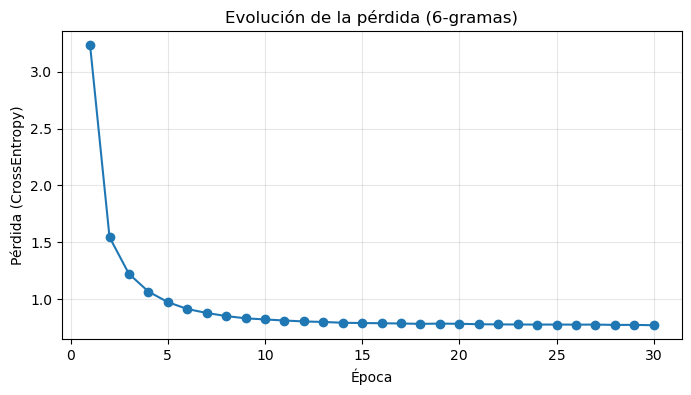

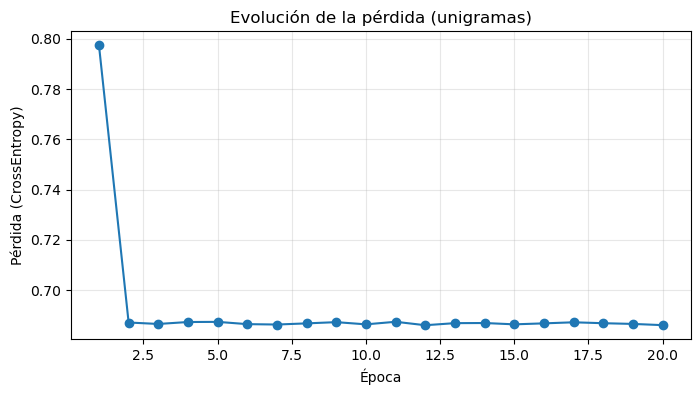

In [14]:
def graficar_historial(historial, titulo):
    if historial is None or len(historial) == 0:
        print(f"No hay historial disponible para {titulo}.")
        return
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(historial) + 1), historial, marker="o", linewidth=1.5)
    plt.title(titulo)
    plt.xlabel("Época")
    plt.ylabel("Pérdida (CrossEntropy)")
    plt.grid(True, alpha=0.3)
    plt.show()

historial_6g_existente = 'historial_6g' in globals()
historial_1g_existente = 'historial_1g' in globals()

if historial_6g_existente:
    graficar_historial(historial_6g, "Evolución de la pérdida (6-gramas)")
else:
    print("No se encontró la variable `historial_6g`. Si guardaste el entrenamiento, cárgalo desde disco.")

if historial_1g_existente:
    graficar_historial(historial_1g, "Evolución de la pérdida (unigramas)")
else:
    print("No se encontró la variable `historial_1g`. Si guardaste el entrenamiento, cárgalo desde disco.")

## 12. Extracción y normalización de embeddings


In [15]:
def cargar_modelo_si_es_necesario(nombre_variable, ruta_modelo, tam_vocabulario, dimension_embedding):
    """Carga desde disco (o reutiliza en RAM) el modelo entrenado con los parámetros especificados."""
    if nombre_variable in globals():
        return globals()[nombre_variable]
    ruta = Path(ruta_modelo)
    if not ruta.exists():
        print(f"No se encontró el modelo entrenado en {ruta_modelo}. Ejecuta el entrenamiento o guarda el modelo.")
        return None
    modelo = ModeloWord2Vec(tam_vocabulario, dimension_embedding)
    modelo.load_state_dict(torch.load(ruta, map_location="cpu"))
    modelo.eval()
    globals()[nombre_variable] = modelo
    return modelo


def obtener_embeddings(modelo, token_por_indice):
    """Extrae la matriz de embeddings y devuelve un diccionario token → vector numpy."""
    if modelo is None:
        return None
    with torch.no_grad():
        matriz = modelo.embeddings.weight.detach().cpu().numpy()
    embeddings = {token_por_indice[i]: matriz[i] for i in range(len(token_por_indice))}
    return embeddings

modelo_6g = cargar_modelo_si_es_necesario(
    nombre_variable="modelo_6g",
    ruta_modelo="modelos/word2vec_6g.pt",
    tam_vocabulario=len(indice_6g),
    dimension_embedding=configuracion_6g["dimension_embedding"]
)

modelo_1g = cargar_modelo_si_es_necesario(
    nombre_variable="modelo_1g",
    ruta_modelo="modelos/word2vec_1g.pt",
    tam_vocabulario=len(indice_1g),
    dimension_embedding=configuracion_1g["dimension_embedding"]
)

embeddings_6g = obtener_embeddings(modelo_6g, token_6g)
embeddings_1g = obtener_embeddings(modelo_1g, token_1g)

print(f"Embeddings 6-gramas disponibles: {len(embeddings_6g) if embeddings_6g else 0}")
print(f"Embeddings unigramas disponibles: {len(embeddings_1g) if embeddings_1g else 0}")


Embeddings 6-gramas disponibles: 424
Embeddings unigramas disponibles: 8


## 13. Búsqueda de vecinos más cercanos


In [16]:
def similitud_coseno(vector_a, vector_b):
    if vector_a is None or vector_b is None:
        return np.nan
    numerador = np.dot(vector_a, vector_b)
    denominador = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    if denominador == 0:
        return np.nan
    return numerador / denominador


def vecinos_cercanos(token_objetivo, embeddings, k=5):
    if embeddings is None or token_objetivo not in embeddings:
        print(f"El token {token_objetivo} no está disponible.")
        return None
    vector_objetivo = embeddings[token_objetivo]
    puntajes = []
    for token, vector in embeddings.items():
        if token == token_objetivo:
            continue
        puntaje = similitud_coseno(vector_objetivo, vector)
        puntajes.append((token, puntaje))
    puntajes.sort(key=lambda x: x[1], reverse=True)
    return puntajes[:k]

# Ejemplos de uso (modifica según los tokens que quieras inspeccionar):
if embeddings_6g:
    token_prueba = "2-2-2-2-2-2"
    vecinos = vecinos_cercanos(token_prueba, embeddings_6g, k=8)
    if vecinos:
        print(f"Vecinos cercanos para {token_prueba}:")
        for token, puntaje in vecinos:
            print(f"  {token:>15s}  similitud={puntaje:.4f}")
else:
    print("Embeddings de 6-gramas no disponibles.")

if embeddings_1g:
    token_prueba = "2"
    vecinos = vecinos_cercanos(token_prueba, embeddings_1g, k=7)
    if vecinos:
        print(f"\nVecinos cercanos para etapa {token_prueba}:")
        for token, puntaje in vecinos:
            descripcion = ETIQUETAS_ETAPAS.get(int(token), token)
            print(f"  {token} ({descripcion})  similitud={puntaje:.4f}")


Vecinos cercanos para 2-2-2-2-2-2:
      0-2-2-2-2-2  similitud=0.5565
      5-2-2-2-2-2  similitud=0.5004
      2-2-2-2-2-3  similitud=0.4949
      2-2-2-2-2-5  similitud=0.4943
      2-2-2-2-2-6  similitud=0.4587
      1-2-2-2-2-2  similitud=0.4398
      4-6-2-2-2-2  similitud=0.4074
      3-2-2-2-2-2  similitud=0.4071

Vecinos cercanos para etapa 2:
  6 (Movimiento)  similitud=0.3101
  5 (REM)  similitud=0.2910
  1 (N1)  similitud=0.2460
  0 (Vigilia (W))  similitud=0.2148
  3 (N3)  similitud=0.1659
  7 (Sin clasificar)  similitud=-0.0125
  4 (N4)  similitud=-0.0576


## 14. Visualización en 2D con UMAP


In [17]:
# Visualiza embeddings en 2D con UMAP (métrica coseno) y Plotly

def proyectar_umap_interactivo(embeddings, titulo, max_tokens=200, n_vecinos=15, min_distancia=0.1):
    """Proyecta embeddings en 2D con UMAP (métrica coseno) y genera una gráfica interactiva Plotly."""
    if embeddings is None or len(embeddings) == 0:
        print(f"No hay embeddings disponibles para {titulo}.")
        return
    if max_tokens is None or max_tokens <= 0:
        tokens = list(embeddings.keys())
    else:
        tokens = list(embeddings.keys())[:max_tokens]
    if not tokens:
        print(f"No hay tokens para proyectar en {titulo}.")
        return
    matriz = np.stack([embeddings[token] for token in tokens])
    reductor = UMAP(
        n_components=2,
        n_neighbors=n_vecinos,
        min_dist=min_distancia,
        metric="cosine",
        random_state=42
    )
    proyeccion = reductor.fit_transform(matriz)

    datos = pd.DataFrame({
        "token": tokens,
        "UMAP1": proyeccion[:, 0],
        "UMAP2": proyeccion[:, 1]
    })
    fig = px.scatter(
        datos,
        x="UMAP1",
        y="UMAP2",
        color="UMAP1",
        color_continuous_scale="Viridis",
        text="token",
        hover_name="token",
        title=f"Proyección UMAP 2D — {titulo}"
    )
    fig.update_traces(marker=dict(size=7, opacity=0.9), textposition="top center", textfont=dict(size=8))
    fig.update_layout(
        template="plotly_dark",
        width=900,
        height=620,
        paper_bgcolor="black",
        plot_bgcolor="black",
        xaxis_title="UMAP1",
        yaxis_title="UMAP2",
        showlegend=False,
        coloraxis_colorbar=dict(title="UMAP1")
    )
    fig.show()

proyectar_umap_interactivo(embeddings_6g, "6-gramas", max_tokens=1006)
proyectar_umap_interactivo(embeddings_1g, "Unigramas", max_tokens=len(embeddings_1g) if embeddings_1g else 0)

/home/penguin/miniconda3/envs/redesneu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/home/penguin/miniconda3/envs/redesneu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/penguin/miniconda3/envs/redesneu/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



### Interpretación de la proyección UMAP 2D

Esta visualización condensa cada embedding en dos componentes no lineales optimizados por UMAP para preservar vecindades relevantes. Cada punto representa un token n-grama:

- La posición horizontal (UMAP1) y vertical (UMAP2) muestran qué tokens comparten contextos; distancias cortas implican transiciones de sueño parecidas.
- El mapa de color reproduce el valor numérico de UMAP1: tonos púrpura→amarillo indican la posición relativa en el primer eje, sin unidades físicas.
- Las etiquetas sobre cada punto facilitan detectar clústeres clínicamente relevantes, transiciones graduales u outliers dentro del vocabulario de 6-gramas.

## 15. Visualización interactiva 3D con UMAP


In [18]:
# Visualiza embeddings en 3D con UMAP + Plotly

def proyectar_umap_3d_interactivo(embeddings, titulo, max_tokens=200, n_vecinos=15, min_distancia=0.1):
    """Proyecta embeddings en 3D con UMAP y visualiza con Plotly Scatter3D."""
    if embeddings is None or len(embeddings) == 0:
        print(f"No hay embeddings disponibles para {titulo}.")
        return
    if max_tokens is None or max_tokens <= 0:
        tokens = list(embeddings.keys())
    else:
        tokens = list(embeddings.keys())[:max_tokens]
    if not tokens:
        print(f"No hay tokens para proyectar en {titulo}.")
        return
    matriz = np.stack([embeddings[token] for token in tokens])
    reductor = UMAP(
        n_components=3,
        n_neighbors=n_vecinos,
        min_dist=min_distancia,
        metric="cosine",
        random_state=42
    )
    proyeccion = reductor.fit_transform(matriz)

    datos = pd.DataFrame({
        "token": tokens,
        "UMAP1": proyeccion[:, 0],
        "UMAP2": proyeccion[:, 1],
        "UMAP3": proyeccion[:, 2]
    })
    fig = px.scatter_3d(
        datos,
        x="UMAP1",
        y="UMAP2",
        z="UMAP3",
        color="UMAP1",
        color_continuous_scale="Viridis",
        text="token",
        hover_name="token",
        title=f"Proyección UMAP 3D — {titulo}"
    )
    fig.update_traces(marker=dict(size=4, opacity=0.85), textposition="top center", textfont=dict(size=6))
    fig.update_layout(
        template="plotly_dark",
        width=900,
        height=680,
        paper_bgcolor="black",
        scene=dict(
            bgcolor="black",
            xaxis_title="UMAP1",
            yaxis_title="UMAP2",
            zaxis_title="UMAP3"
        ),
        showlegend=False,
        coloraxis_colorbar=dict(title="UMAP1")
    )
    fig.show()

proyectar_umap_3d_interactivo(embeddings_6g, "6-gramas", max_tokens=200)
proyectar_umap_3d_interactivo(embeddings_1g, "Unigramas", max_tokens=len(embeddings_1g) if embeddings_1g else 0)

/home/penguin/miniconda3/envs/redesneu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



/home/penguin/miniconda3/envs/redesneu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/penguin/miniconda3/envs/redesneu/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



### Interpretación de la proyección UMAP 3D

La proyección tridimensional incorpora un tercer eje de UMAP (UMAP3) para capturar más estructura del espacio de embeddings:

- Los ejes UMAP1, UMAP2 y UMAP3 ubican cada token en el volumen; cúmulos compactos delatan secuencias con dinámicas nocturnas similares.
- El color vuelve a codificar UMAP1, lo que permite comparar la orientación con la vista 2D y detectar gradientes o transiciones específicas.
- Las etiquetas se dibujan en el espacio 3D para resaltar subgrupos clínicamente relevantes que emergen al incluir UMAP3 (por ejemplo, variantes N2↔REM separadas de otras cadenas).

## 16. Clustering con K-Means sobre UMAP

El objetivo es cuantificar los patrones que observamos visualmente en las proyecciones UMAP. Vamos a:

1. Recalcular las coordenadas UMAP (2D) para 6-gramas y unigramas y guardarlas en **DataFrame** para reutilizarlas.
2. Aplicar K-Means sobre esas coordenadas para identificar grupos de tokens con trayectorias de sueño similares.
3. Evaluar cada modelo con la inercia y el coeficiente *silhouette* (medida de separación entre clústeres).
4. Visualizar los clústeres coloreando los puntos según la etiqueta asignada para interpretar qué tipo de secuencias describe cada grupo.

Esto nos dice qué segmentos del vocabulario comparten dinámica temporal parecida, sirve para detectar patrones recurrentes y permite usar las etiquetas de clúster como nuevas características para análisis clínico o modelos supervisados posteriores.



In [19]:
# Utilidades para congelar las coordenadas UMAP y ejecutar K-Means

def generar_umap_dataframe(embeddings, max_tokens=500, n_vecinos=15, min_distancia=0.1, random_state=42):
    """Calcula UMAP 2D (métrica coseno) y devuelve un DataFrame token + coordenadas."""
    if embeddings is None or len(embeddings) == 0:
        print("No hay embeddings disponibles.")
        return None
    tokens = list(embeddings.keys())[:max_tokens] if max_tokens else list(embeddings.keys())
    if not tokens:
        print("No hay tokens para proyectar.")
        return None
    matriz = np.stack([embeddings[token] for token in tokens])
    reductor = UMAP(
        n_components=2,
        n_neighbors=min(n_vecinos, len(tokens) - 1),
        min_dist=min_distancia,
        metric="cosine",
        random_state=random_state
    )
    coordenadas = reductor.fit_transform(matriz)
    return pd.DataFrame({
        "token": tokens,
        "UMAP1": coordenadas[:, 0],
        "UMAP2": coordenadas[:, 1]
    })


def aplicar_kmeans(df_umap, n_clusters, descripcion=""):
    """Ajusta K-Means sobre las coordenadas UMAP y reporta inercia + silhouette."""
    if df_umap is None or df_umap.empty:
        print(f"No hay datos UMAP para {descripcion}.")
        return None, None, None
    matriz = df_umap[["UMAP1", "UMAP2"]].values
    modelo = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    etiquetas = modelo.fit_predict(matriz)
    df_clusters = df_umap.copy()
    df_clusters["cluster"] = etiquetas
    sil = silhouette_score(matriz, etiquetas) if n_clusters > 1 else np.nan
    print(f"K-Means {descripcion}: k={n_clusters} | inercia={modelo.inertia_:.2f} | silhouette={sil:.3f}")
    return df_clusters, modelo, sil



In [20]:
# Configuración de UMAP (para congelar las coordenadas antes del clustering)
PARAMETROS_UMAP = {
    "max_tokens": 600,   # límite superior para acelerar el ajuste
    "n_vecinos": 20,     # capta contextos locales y parte de la estructura global
    "min_distancia": 0.05,
    "random_state": 42
}

umap_6g = generar_umap_dataframe(embeddings_6g, **PARAMETROS_UMAP)
clusters_6g, modelo_6g, sil_6g = aplicar_kmeans(umap_6g, n_clusters=5, descripcion="6-gramas")

# Para unigramas usamos todos los tokens (8) y n_vecinos reducido para evitar advertencias
umap_1g = generar_umap_dataframe(embeddings_1g, max_tokens=len(embeddings_1g) if embeddings_1g else 0, n_vecinos=5, min_distancia=0.1)
clusters_1g, modelo_1g, sil_1g = aplicar_kmeans(umap_1g, n_clusters=3, descripcion="unigramas")



/home/penguin/miniconda3/envs/redesneu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



K-Means 6-gramas: k=5 | inercia=269.39 | silhouette=0.346
K-Means unigramas: k=3 | inercia=2.29 | silhouette=0.327


/home/penguin/miniconda3/envs/redesneu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [21]:
# Visualiza los clústeres resultantes coloreados por etiqueta asignada

def graficar_clusters(df_clusters, titulo):
    if df_clusters is None or df_clusters.empty:
        print(f"No hay clústeres que mostrar para {titulo}.")
        return
    fig = px.scatter(
        df_clusters,
        x="UMAP1",
        y="UMAP2",
        color=df_clusters["cluster"].astype(str),
        text="token",
        title=f"K-Means sobre UMAP — {titulo}",
        color_discrete_sequence=px.colors.qualitative.Dark24,
        hover_data={"cluster": True, "token": True}
    )
    fig.update_traces(marker=dict(size=6, opacity=0.9), textposition="top center", textfont=dict(size=7))
    fig.update_layout(
        template="plotly_dark",
        width=900,
        height=620,
        paper_bgcolor="black",
        plot_bgcolor="black",
        legend_title="Cluster"
    )
    fig.show()


graficar_clusters(clusters_6g, "6-gramas")
graficar_clusters(clusters_1g, "Unigramas")



### Cómo interpretar los clústeres

- **Inercia** mide la compacidad interna: valores más bajos significan clústeres más cerrados (pero siempre decrece al aumentar *k*).
- **Silhouette** (−1 a 1) indica qué tan bien separado está cada clúster respecto a los demás; >0.3 ya sugiere separación razonable.
- **Distribución de tokens** por clúster permite etiquetar cada grupo (por ejemplo, cadenas dominadas por N2, transiciones hacia REM, etc.).

Con estas métricas y las gráficas coloreadas podemos decidir si los clústeres son clínicamente coherentes, ajustar *k* si la separación es pobre, y reutilizar las etiquetas como características para comparar pacientes o entrenar clasificadores.

